In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from lib import evaluations
import matplotlib.pyplot as plt
import numpy as np
from lib import utility 

In [3]:
t= np.ones(64)*10
s= np.ones(64)*4

np.max((t,s))

10.0

In [4]:
def plot_kf_traj(pred, actual, sigma, start=0):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    
    x_max = pred[start:, 0] +sigma[start:, 0,0]
    y_max = pred[start, 0] + sigma[start:, 0,0]
    
    vmax = np.max((x_max, y_max)) + 0.5
    
    x_min = pred[start:, 0]  -sigma[start:, 1,1]
    y_min = pred[start, 0] - sigma[start:, 1,1]
    
    vmin = np.min((x_min, y_min)) - 0.5
    
    for j in range(state_dim):
        plt.figure(figsize=(8, 6))


        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Predicted"
        actual_label_arg['label'] = "Ground Truth"
        plt.plot(range(timesteps-start),
                 pred[start:, j],
#                      c=color(0),
                 **predicted_label_arg)
        plt.plot(range(timesteps-start),
                 actual[start:, j],
#                      c=color(1),
                 **actual_label_arg)

        conf_min = pred[start:, j] - np.sqrt(sigma[start:, j, j]) 
        conf_max = pred[start:, j] + np.sqrt(sigma[start:, j, j])
        plt.fill_between(range(timesteps-start), 
                         conf_min, conf_max, 
                         alpha=0.5)

        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))

        plt.title(f"State #{j} ")
        plt.xlabel("Timesteps")
        plt.ylabel("Value")
#             plt.legend()
#             plt.ylim(-2, 2)
        plt.ylim(vmin, vmax)
        plt.show()


In [188]:

def plot_jacobian(results, trajectories=range(5), start=0):
    pred_states = results['predicted_states']
    jacobian = results['dyn_jac']

    
    contact = np.argmax(results['contact_states'])

    intervals = int((pred_states.shape[1]-1 -contact)/4.0)
    actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[1]-1]

    for i in trajectories:
        pred = pred_states[i]
        jac = jacobian[i]
        actual = actual_states[i]
        
        jac_update = jac @ np.expand_dims(pred[:-1], -1)
        
        jac_update = utility.denormalize(jac_update,mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])[:,:,0]
        pred = utility.denormalize(pred, mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(20,10))
        axes = axes.ravel()
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            ax.plot(jac_update[:, 0], jac_update[:, 1],c="c", alpha=0.4 )
            ax.plot(pred[:, 0], pred[:,1], c="b", alpha=0.4)
            ax.plot(actual[:,0], actual[:,1], c="orange", alpha=0.4)
            
            if t>0:
                ax.scatter(jac_update[start+t-1, 0], jac_update[start+t-1, 1],c="c",)
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
        
        


def eval_full_rollout(results, trajectories=range(5), start=0, plot="all", plot_cov = False):
    contact = np.argmax(results['contact_states'])
    actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
    predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
    
    dyn_states, dyn_sigmas = utility.denormalize_state(results['dyn_states'], results['dyn_sigmas'])
    
    meas_states, meas_sigmas = utility.denormalize_state(results['meas_states'], results['meas_sigmas'])
    intervals = int((predicted_states.shape[1]-1 -contact)/4.0)
    print(intervals)
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[1]-1]
    
    for i in trajectories:
        pred = predicted_states[i]
        sigma = predicted_sigmas[i]
        actual = actual_states[i]
        dyn = dyn_states[i]
        dyn_sig = dyn_sigmas[i]
        meas = meas_states[i]
        meas_sig = meas_sigmas[i]
        
        
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(20,5))
        axes = axes.ravel()
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
            
            if plot == "all":
                ax.scatter(dyn[start+t, 0], dyn[start+t,1], c='c')
                ax.scatter(meas[start+t, 0], meas[start+t,1], c='fuchsia')

                draw_2d(ax, dyn_sig[start+t], dyn[start+t], color='c')
                draw_2d(ax, meas_sig[start+t], meas[start+t], color='fuchsia')
                
                x_max = np.max(pred[start:, 0] + sigma[start:, 0,0]) + 0.005
                y_max = np.max(pred[start:, 1] + sigma[start:, 1,1])+ 0.005

                x_min = np.min(pred[start:, 0]  - sigma[start:, 0,0])- 0.005
                y_min = np.min(pred[start:, 1] - sigma[start:, 1,1])- 0.005

                max_diff = np.max((x_max-x_min, y_max-y_min))

                x_max = x_min + max_diff
                y_max = y_min + max_diff

            elif plot == 'dyn':
                ax.scatter(dyn[start+t, 0], dyn[start+t,1], c='c')
                width, height = draw_2d(ax, dyn_sig[start+t], dyn[start+t], color='c')
                
#                 print('dyn sig: ', dyn_sig)
                
                x_max = np.max(meas[start:, 0] + width/2.) + 0.001
                y_max = np.max(meas[start:, 1] + height/2.) + 0.001

                x_min = np.min(meas[start:, 0]  - width/2.) - 0.001
                y_min = np.min(meas[start:, 1] -  height/2.) - 0.001


#                 print("x: ", x_max, x_min, width, height)

                max_diff = np.max((abs(x_max-x_min)/2., abs(y_max-y_min)/2.))

                x_max = np.max(meas[start:,0]) + max_diff
                x_min = np.min(meas[start:,0]) - max_diff
#                 x_min = (x_max - x_min)/2. - max_diff

                y_max =  np.max(meas[start:,1]) + max_diff
                y_min =  np.min(meas[start:,1]) - max_diff
            
            elif plot == 'meas':
                ax.scatter(meas[start+t, 0], meas[start+t,1], c='fuchsia')
                width, height = draw_2d(ax, meas_sig[start+t], meas[start+t], color='fuchsia')
#                 print(meas_sig)

              
                x_max = np.max(meas[start:, 0] + width/2.) + 0.001
                y_max = np.max(meas[start:, 1] + height/2.) + 0.001

                x_min = np.min(meas[start:, 0]  - width/2.) - 0.001
                y_min = np.min(meas[start:, 1] -  height/2.) - 0.001


#                 print("x: ", x_max, x_min, width, height)

                max_diff = np.max((abs(x_max-x_min)/2., abs(y_max-y_min)/2.))

                x_max = np.max(meas[start:,0]) + max_diff
                x_min = np.min(meas[start:,0]) - max_diff
#                 x_min = (x_max - x_min)/2. - max_diff

                y_max =  np.max(meas[start:,1]) + max_diff
                y_min =  np.min(meas[start:,1]) - max_diff

            ax.plot(pred[start:, 0],
                     pred[start:, 1],
                     c='b', alpha=0.4)
            ax.plot(actual[start:, 0],
                     actual[start:, 1],
                     c='orange', alpha=0.4)
            
            ax.set_title("Time: {}".format(t))
            
            if plot_cov: 
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
            if t >= contact:
                ax.set_title("Contact Made. Time: {}".format(t))
        
        fig.suptitle("Plot {} Trajectory: {}".format(plot,i ))

                        
#             ax.set_xlim(x_min, x_max)
#             ax.set_ylim(y_min, y_max)

In [197]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

def draw_2d(ax, covariance, mean, color='g'):
    E, V = np.linalg.eig(covariance)

    angle = np.arctan2(V[0,0], V[0,1]) / np.pi * 180.0
    height = 2*np.sqrt(E[0]*5.99)
    width = 2*np.sqrt(E[1]*5.99)
    el = Ellipse(xy=mean, width=2*np.sqrt(E[1]*5.99), height=2*np.sqrt(E[0]*5.99), angle=angle,
                 color=color, alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
    ax.add_artist(el)
    
    return height, width
    


def eval_2d_rollout(predicted_states,  actual_states,  covariance, contact_states,
                    plot=True, plot_traj=None, start=0, actions=None, arrow=False, plot_cov=False):
    contact = np.argmax(contact_states)
#     print(contact)
    intervals = int((predicted_states.shape[0]-1 -contact)/4.0)
#     print(intervals)
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[0]-1]
    
    if plot:
        timesteps = len(actual_states[0])

        def color(i):
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            return colors[i % len(colors)]

        state_dim = actual_states.shape[-1]
        
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(20,5))
        axes = axes.ravel()
        
        pred = predicted_states
        actual = actual_states
        sigma= covariance
        
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            draw_2d(ax, covariance[start+t], predicted_states[start+t])
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
            
            if actions is not None:
                ax.scatter(actions[start+t, 0], actions[start+t,1], c='red')
                ax.plot(actions[start:, 0], actions[start:,1], c='red', alpha=0.4)
                if arrow: 
                    ax.arrow(actions[start+t, 0], actions[start+t,1], 
                             actions[start+t, 3], 
                             actions[start+t, 4], 
                             head_width=0.01, head_length=0.015, fc='k', ec='k')
                else: 
                    pass
                    ax.scatter(actions[start+t,0] + actions[start+t, 3], 
                            actions[start+t,1] + actions[start+t, 4], c='pink', marker ="*")


            ax.plot(pred[start:, 0],
                     pred[start:, 1],
                     c='b', alpha=0.4)
            ax.plot(actual[start:, 0],
                     actual[start:, 1],
                     c='orange', alpha=0.4)

            rmse = np.sqrt(np.mean(
                (predicted_states[:, start:] - actual_states[:, start:]) ** 2))

            x_max = np.max(pred[start:, 0] + sigma[start:, 0,0]) + 0.005
            y_max = np.max(pred[start:, 1] + sigma[start:, 1,1])+ 0.005
        
            x_min = np.min(pred[start:, 0]  - sigma[start:, 0,0])- 0.005
            y_min = np.min(pred[start:, 1] - sigma[start:, 1,1])- 0.005
            
            max_diff = np.max((x_max-x_min, y_max-y_min))
            
#             x_max = x_min + max_diff
#             y_max = y_min + max_diff
            
#             ax.set_xlim(x_min, x_max)
#             ax.set_ylim(y_min, y_max)
            ax.set_title("Time: {}".format(t))

            if t >= contact:
                ax.set_title("Contact Made. Time: {}".format(t))
        
            ax.set_xlabel("X")
        
            ax.scatter(x_max-0.01, 0, c="black", marker="<")

#         plt.title(f"x vs. y // RMSE = {rmse}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    return plot_times

In [7]:
def img_obs(trajectory, plot_times):
    #get image
    s, observations, controls = trajectory
    fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,10))
    axes = axes.ravel()
    for n, t in enumerate(plot_times): 
        ax = axes[n]
        print(observations['image'][t][::-1,...].shape)
        ax.imshow(observations['image'][t][::-1,...], cmap='gray')
        ax.set_title("Timestep: {}".format(t))

201
9
181
14
[[0, 50, 75, 150, 201, 210, 219, 239], [0, 50, 75, 150, 181, 195, 209, 239]]
[TrajectoriesFile-...tle_push_100.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_100.hdf5" (mode r)>
[TrajectoriesFile-...tle_push_100.hdf5] Existing trajectory count: 100
[TrajectoriesFile-...tle_push_100.hdf5] Opening file...
[TrajectoriesFile-...tle_push_100.hdf5] Closing file...
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


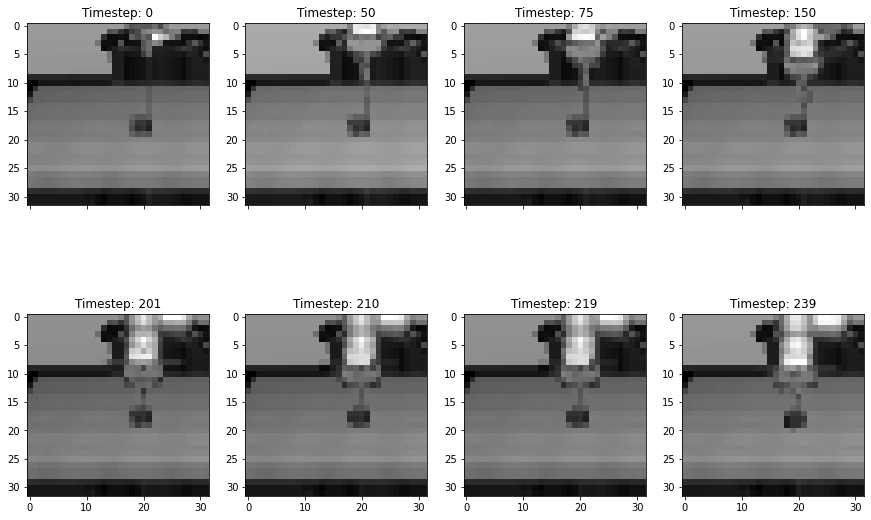

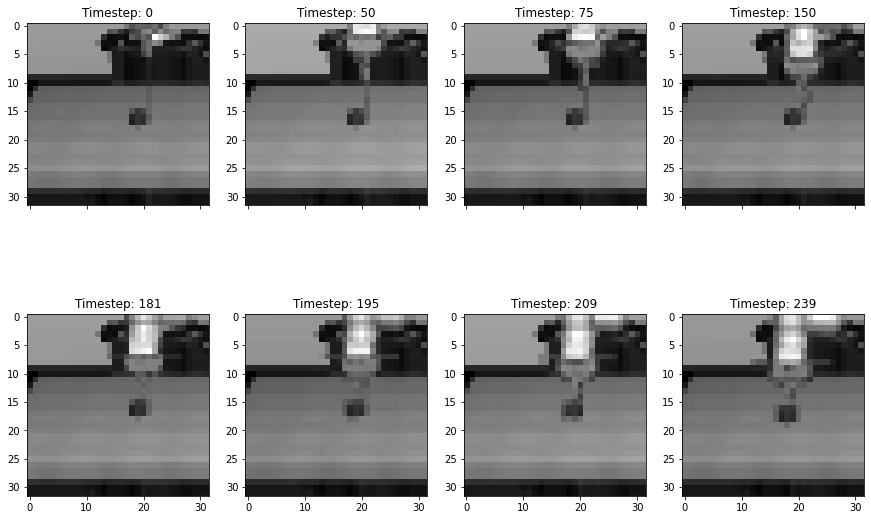

In [12]:
plot_times=[0,0]
from lib import dpf, panda_models, panda_datasets, panda_kf_training, omnipush_datasets

for i in range(2):
    plot_times[i]= eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], plot=False)

print(plot_times)

eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 100))

for i in range(2):
    img_obs(eval_trajectories[i], plot_times[i])

In [195]:
name = "ekfmse_gaps2_freezedyn3"
results = evaluations.ekf_eval_experiment(name, learnable_Q=True)

predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315] )
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))
contact_states = results['contact_states']
actions = utility.denormalize(results['actions'], 
                             mean= [4.6594709e-01, -2.5247163e-03, 8.8094306e-01, 1.2939950e-04,
                                       -5.4364675e-05, -6.1112235e-04, 2.2041667e-01],
                             std= [0.02239027, 0.02356066, 0.0405312, 0.00054858, 0.0005754,
                                       0.00046352, 0.41451886])

# actual = x['actual_states']
# pred = x['[predicted_states]']
# print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))



[buddy-ekfmse_gaps2_freezedyn3] Using device: cuda
[buddy-ekfmse_gaps2_freezedyn3] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': False, 'learnable_Q_dynamics': False, 'meas_lr': 0.0001, 'measurement': 'gaps2', 'measurement_loss': 'mse', 'obs_only': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'ekf', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_gaps2_freezedyn3] Available checkpoint labels: ['0000000000395146', '0000000000395980', 'phase_3_e2e']
100
[TrajectoriesFile-...tle_push_100.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_100.hdf5" (mode r)>
[TrajectoriesFile-...tle_push_100.hdf5] Existing trajectory count: 100
[TrajectoriesFile-...tle_push_100.hdf5] Opening file...
[TrajectoriesFile-..


rsme x: 
0.02519183009596891 
 y:
0.01950615282071335
Sigma average:  [[2.2109536e-02 2.5057881e-05]
 [2.5057881e-05 5.8610113e-03]]


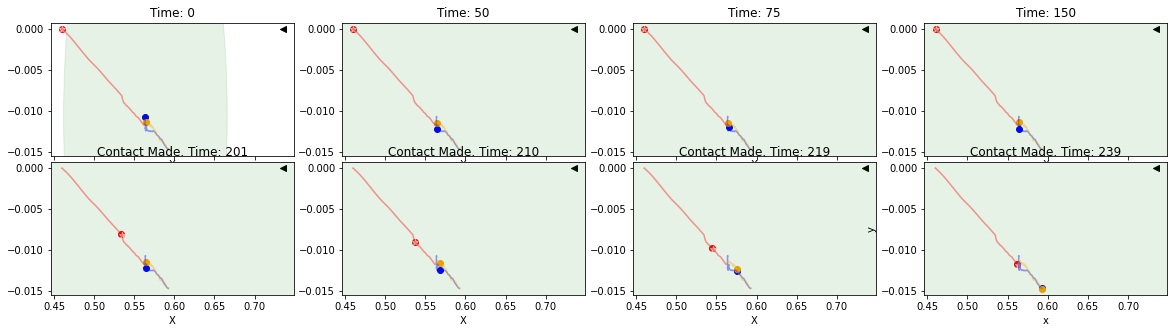

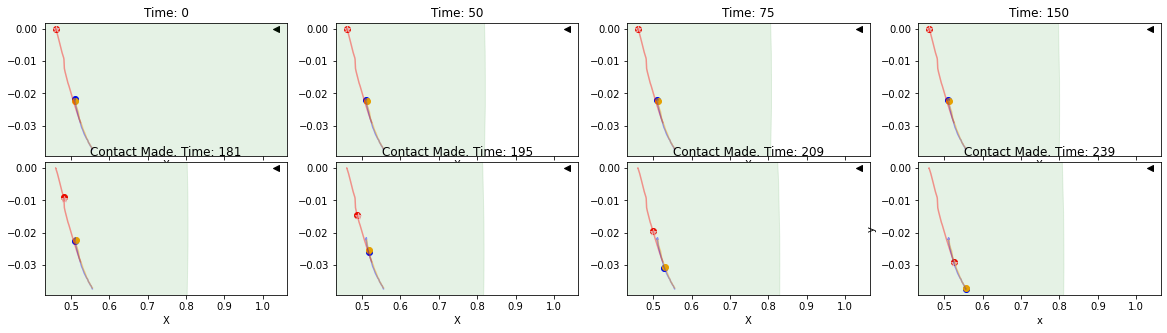

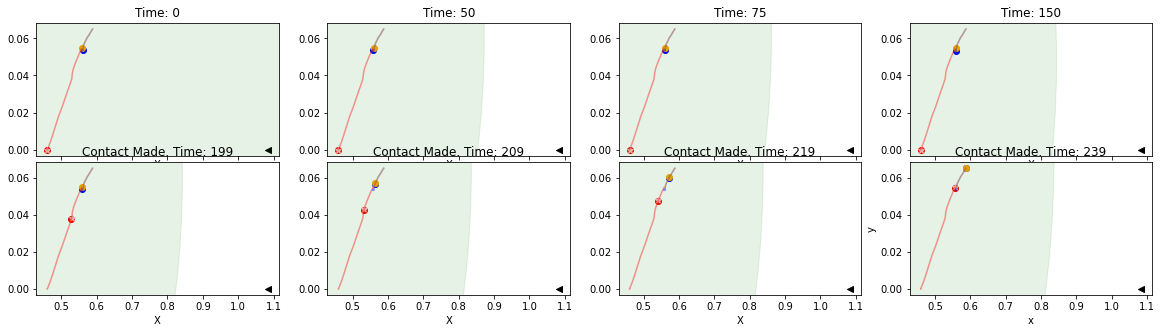

In [199]:
for i in range(3):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], 
                   actions=actions[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
#     print(np.mean(predicted_sigmas[i], 0))

9
9
9


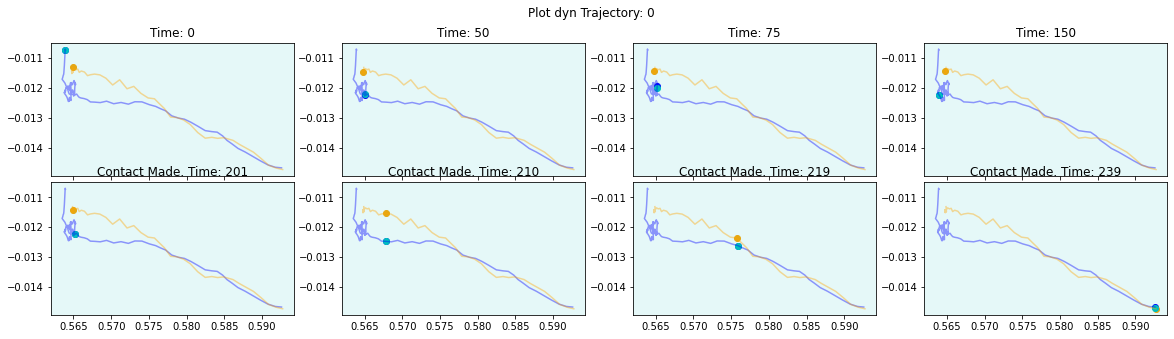

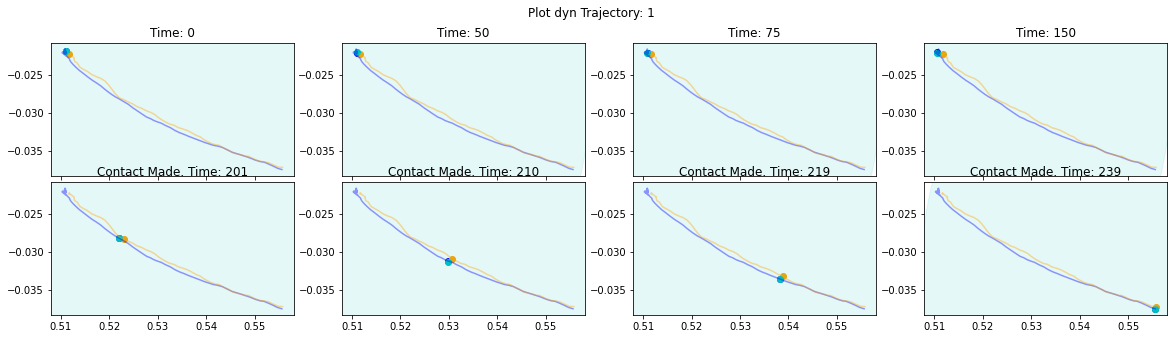

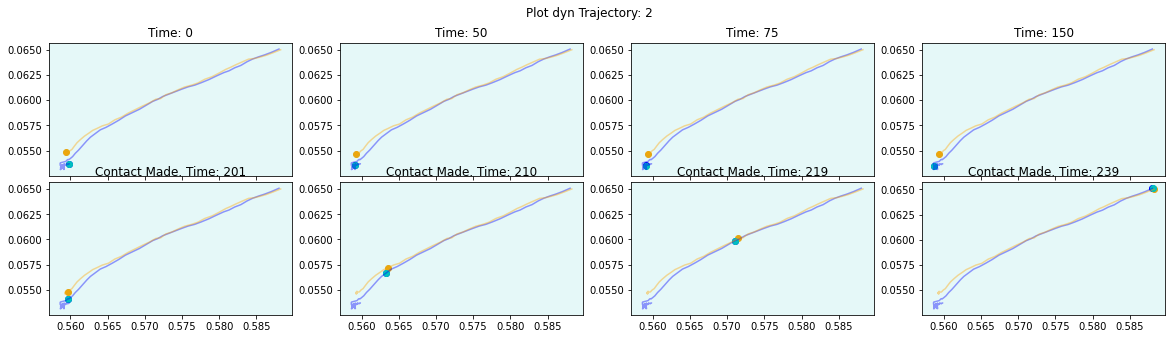

In [189]:
for i in range(3):

    eval_full_rollout(results, trajectories =[i],plot='dyn')
#     eval_full_rollout(results, trajectories =[i],plot='meas')
#     plot_jacobian(results, trajectories=[i])
# i=3

# # eval_full_rollout(results, trajectories =[i],plot='dyn')
# eval_full_rollout(results, trajectories =[i],plot='meas')
# # plot_jacobian(results, trajectories=[i])

9
9
9


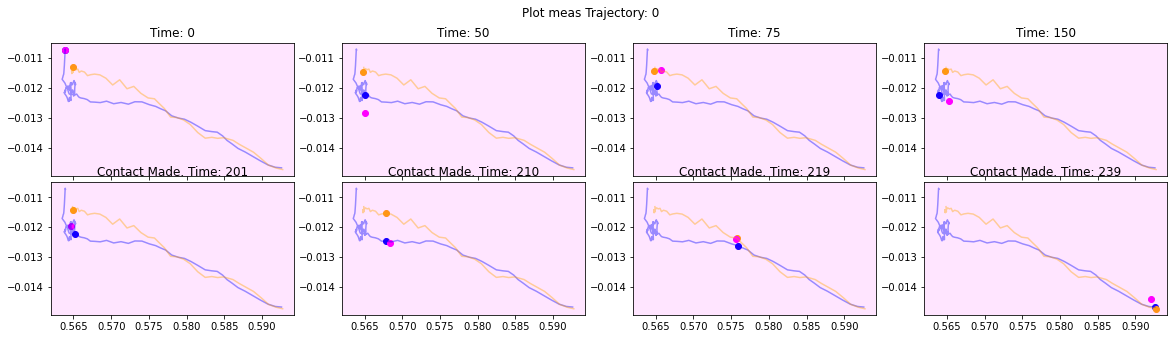

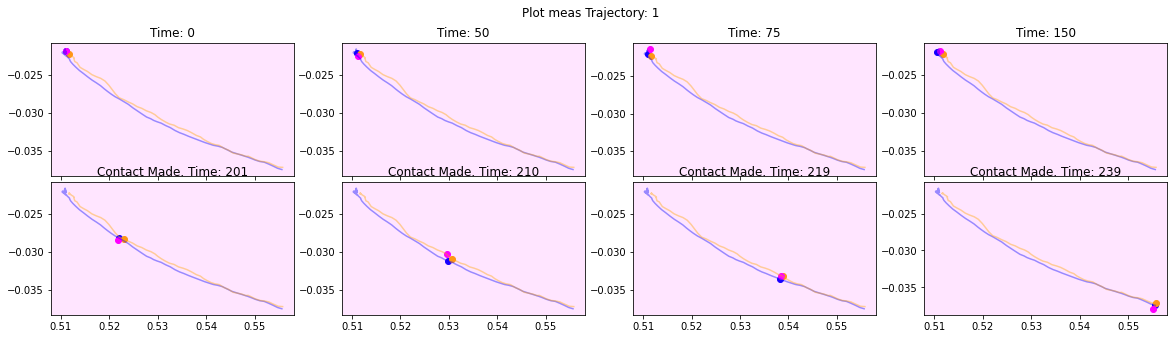

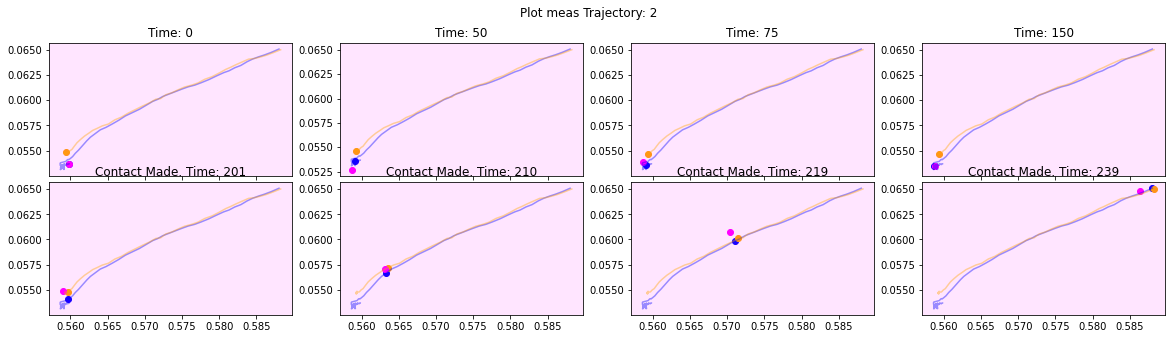

In [190]:
for i in range(3):

#     eval_full_rollout(results, trajectories =[i],plot='dyn')
    eval_full_rollout(results, trajectories =[i],plot='meas')

In [200]:
name = "ekfnll_gaps2_Q_3"
results = evaluations.ekf_eval_experiment(name, learnable_Q=True)

predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315] )
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))
contact_states = results['contact_states']
actions = utility.denormalize(results['actions'], 
                             mean= [4.6594709e-01, -2.5247163e-03, 8.8094306e-01, 1.2939950e-04,
                                       -5.4364675e-05, -6.1112235e-04, 2.2041667e-01],
                             std= [0.02239027, 0.02356066, 0.0405312, 0.00054858, 0.0005754,
                                       0.00046352, 0.41451886])

[buddy-ekfnll_gaps2_Q_3] Using device: cuda
[buddy-ekfnll_gaps2_Q_3] Loaded metadata: {'batch': 128, 'ekf_loss': 'nll', 'epochs': 25, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'meas_lr': 1e-05, 'measurement': 'gaps2', 'measurement_loss': 'nll', 'obs_only': False, 'omnipush dataset': False, 'pretrain epochs': 10, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfnll_gaps2_Q_3] Available checkpoint labels: ['0000000000394786', '0000000000395495', '0000000000396200', '0000000000396912', '0000000000397160', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
100
[TrajectoriesFile-...tle_push_100.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_100.hdf5" (mode r)>
[TrajectoriesFile-...tle_push_100.hdf5] Existing


rsme x: 
0.028228584482078108 
 y:
0.14526982074025638
Sigma average:  [[0.00058381 0.00024804]
 [0.00024804 0.00754877]]


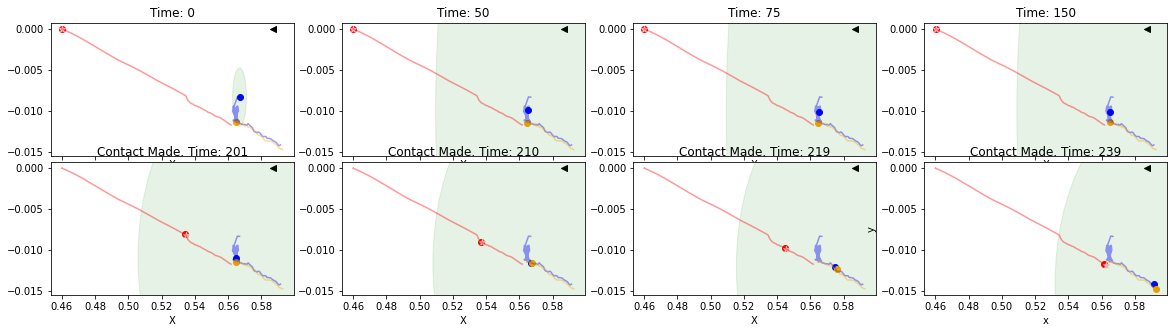

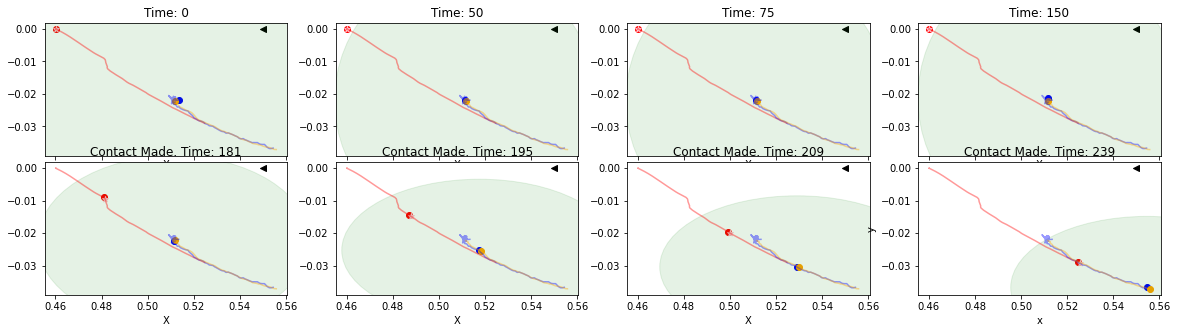

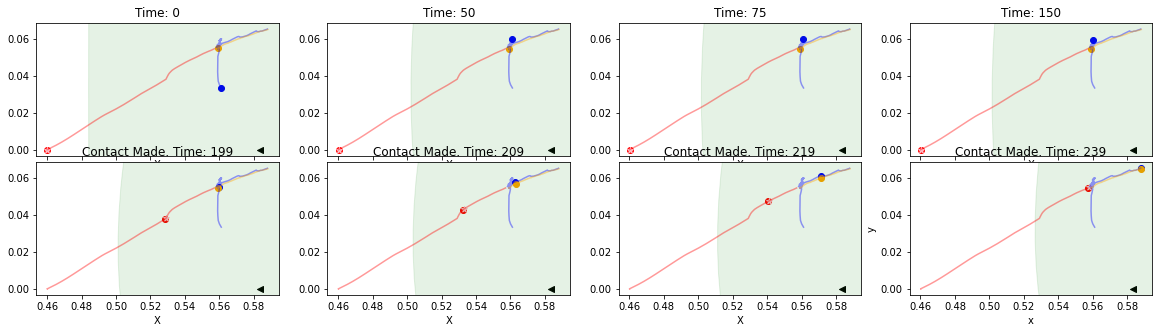

In [202]:
for i in range(3):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], 
                   actions=actions[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
#     print(np.mean(predicted_sigmas[i], 0))

9
9
9


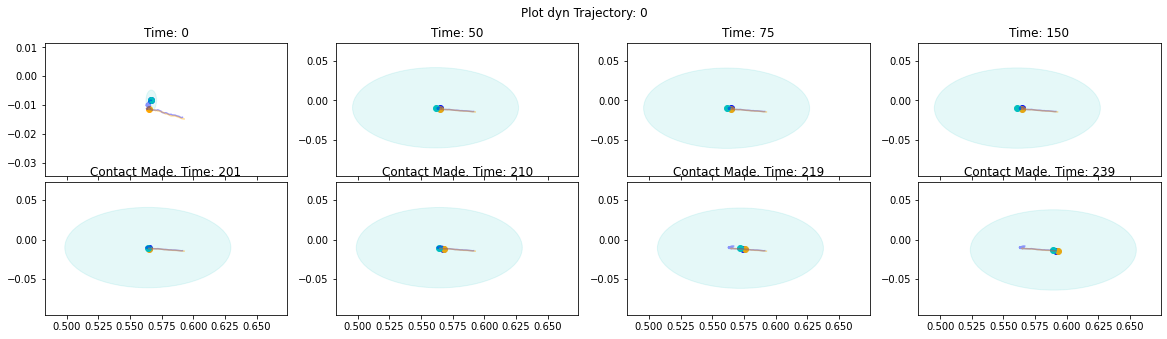

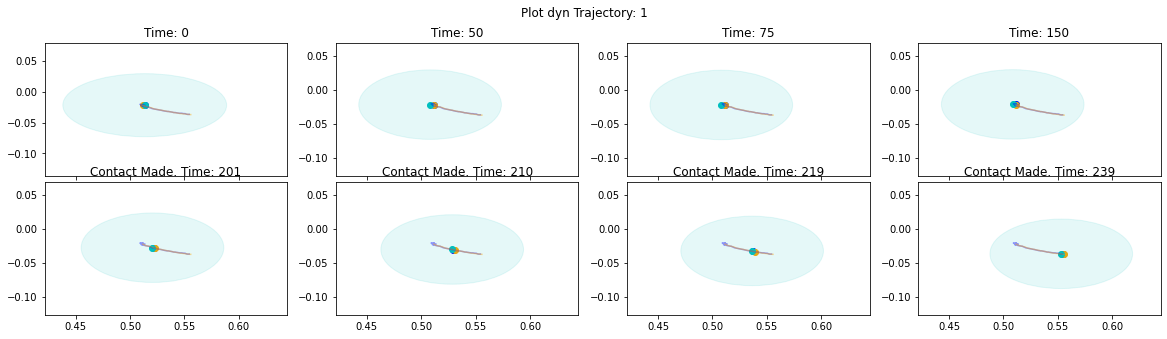

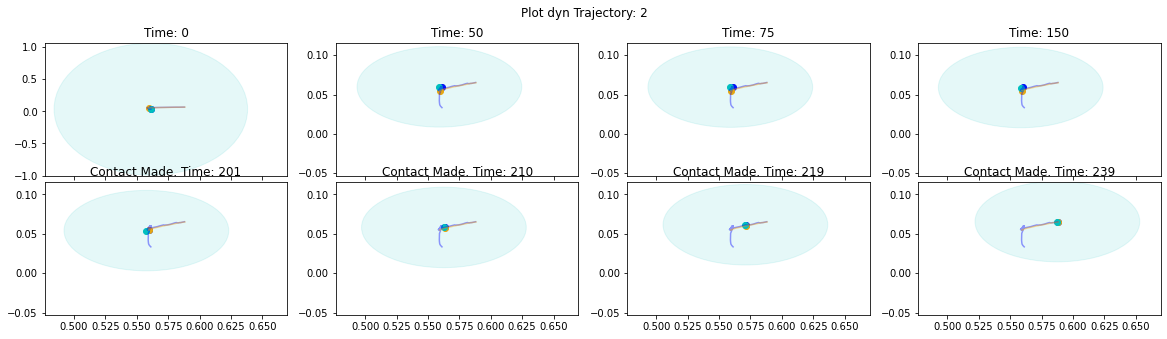

In [205]:
for i in range(3):

    eval_full_rollout(results, trajectories =[i],plot='dyn', plot_cov=True)
#     eval_full_rollout(results, trajectories =[i],plot='meas')
#     plot_jacobian(results, trajectories=[i])
# i=3

# # eval_full_rollout(results, trajectories =[i],plot='dyn')
# eval_full_rollout(results, trajectories =[i],plot='meas')
# plot_jacobian(results, trajectories=[i])

9
9
9


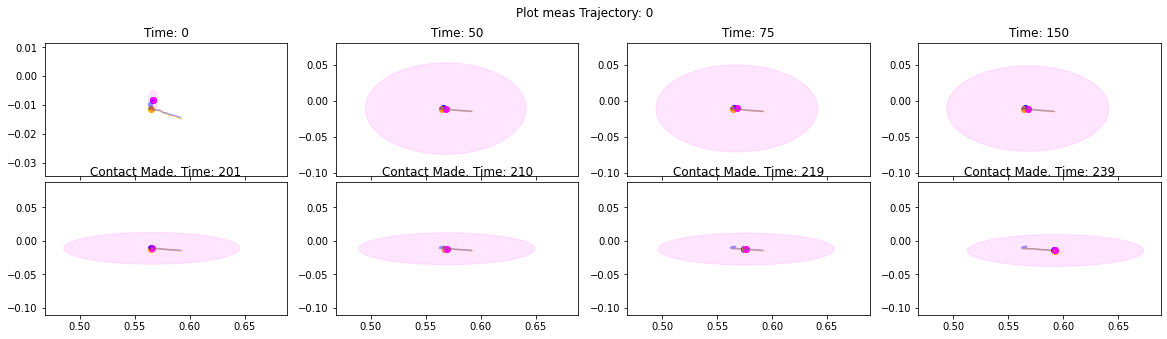

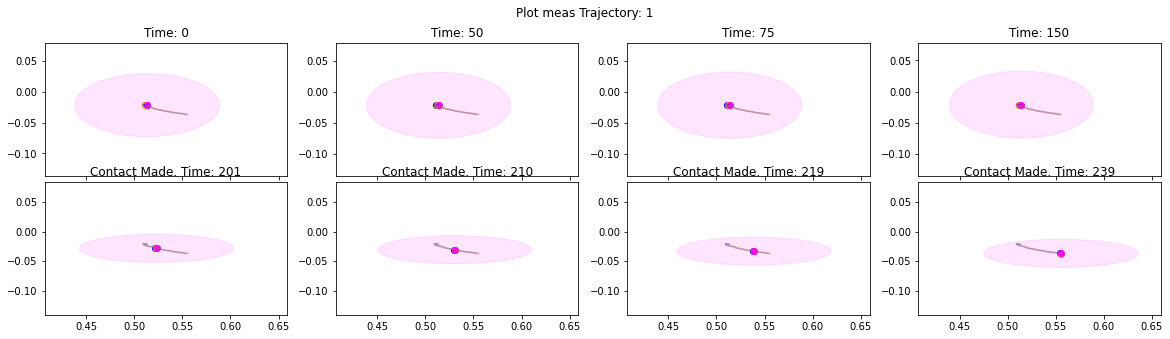

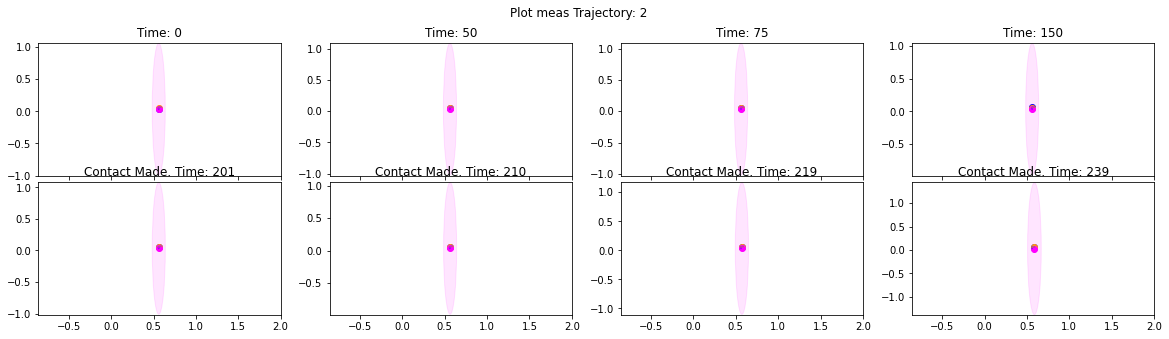

In [208]:
for i in range(3):

    eval_full_rollout(results, trajectories =[i],plot='meas', plot_cov=True)
#     eval_full_rollout(results, trajectories =[i],plot='meas')
#     plot_jacobian(results, trajectories=[i])
# i=3

[buddy-ekfmse_gaps2_freezedyn3] Using device: cuda
[buddy-ekfmse_gaps2_freezedyn3] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': False, 'learnable_Q_dynamics': False, 'meas_lr': 0.0001, 'measurement': 'gaps2', 'measurement_loss': 'mse', 'obs_only': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'ekf', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_gaps2_freezedyn3] Available checkpoint labels: ['0000000000395146', '0000000000395980', 'phase_3_e2e']
100
[TrajectoriesFile-...tle_push_100.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_100.hdf5" (mode r)>
[TrajectoriesFile-...tle_push_100.hdf5] Existing trajectory count: 100
[TrajectoriesFile-...tle_push_100.hdf5] Opening file...
[TrajectoriesFile-..

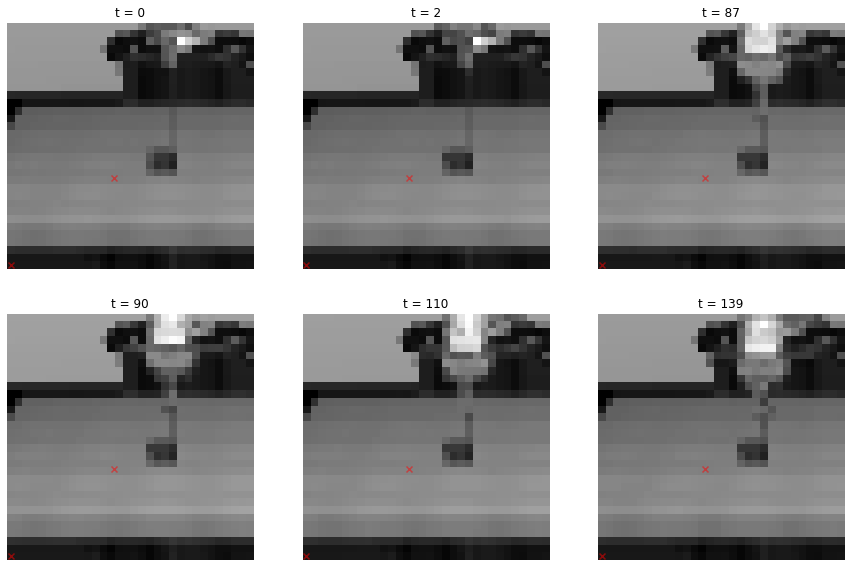

In [105]:
model, buddy, eval_trajectories = evaluations.init_experiment(name,
                    fusion_type=None,
                    omnipush=False,
                    learnable_Q=False,
                    load_checkpoint=None)

traj = 0

def project(X, Y, Z):
    # Camera fov
    fov = 45. / 180. * np.pi
    # images are 96 x 96
    # tan(fov) = Y / Z = y / f
    # y / f = tan(fov)
    # f = y / tan(fov / 2)
    f = 16. / np.tan(fov / 2)
    x = -f * X / Z + 32.0/2.0
    y = -f * Y / Z + 32.0/2.0
    return x, y

from scipy.spatial.transform import Rotation as R
R_world_camera = R.from_quat([0.43, 0.43, 0.56, 0.56]).as_matrix()
t_world_camera = np.array([1.6, 0.4, 1.45])

T_world_camera = np.identity(4)
T_world_camera[:3,:3] = R_world_camera
T_world_camera[:3,3] = t_world_camera
T_camera_world = np.linalg.inv(T_world_camera)
R_camera_world = T_camera_world[:3,:3]
t_camera_world = T_camera_world[:3,3]
assert np.allclose(R_camera_world, R_world_camera.T)
assert np.allclose(t_camera_world[:,np.newaxis], -R_world_camera.T @ t_world_camera[:,np.newaxis])
    
pred = predicted_states[traj]
actual = actual_states[traj]
#     plot_times = (0, 5, 20, 50, 80, 95, 110, 125, 139)
#     fig, axes = plt.subplots(3, 3, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,15))
plot_times = (0, 2, 87, 90, 110, 139)
fig, axes = plt.subplots(2, 3, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,10))
#     axes = [axes]
axes = axes.ravel()
for j, t in enumerate(plot_times):
    states, observations, controls = eval_trajectories[traj]
    axes[j].set_title(f"t = {t}")
    start_row = 0
    start_col = 0
    size = 64
#         start_row = 0
#         start_col = 0
#         size = 96
    axes[j].imshow(observations['image'][t,], cmap='gray')
    print(observations['image'][t,].shape)
#         axes[j].imshow(observations['raw_image'][t,:,:,:])
    axes[j].invert_yaxis()
    axes[j].set_axis_off()
    print(pred.shape)
    
    X = actual[t, 0] - 0.5 # offset from mujoco set_origin() in robosuite env
    Y = actual[t, 1] + 0.3 # offset from mujoco set_origin() in robosuite env
    Z = np.zeros_like(X) + 0.83419913   # offset by table height
    XYZ_world = np.stack([X, Y, Z], axis=-1)
    print(XYZ_world)
    XYZ_camera = XYZ_world @ R_camera_world.T + t_camera_world + np.array([0,0,0])
    x, y = project(XYZ_camera[0], XYZ_camera[1], XYZ_camera[2])
    
    print(x, y)
    
#     x -= start_col
#     y -= start_row
#     mask = np.logical_and(
#         x >= 0,
#         np.logical_and(
#             x <= size,
#             np.logical_and(
#                 y >= 0,
#                 y <= size
#             )
#         )
#     )
    axes[j].scatter(0, 0, alpha=0.5, c='r', marker='x')

    axes[j].scatter(x, y, alpha=0.5, c='r', marker='x')
#         axes[j].scatter(x, y)

In [98]:
np.array([0.5648847 ,  -0.01130973 , 0.83419913]) - np.array([0.5, -0.3, 0])

array([0.0648847 , 0.28869027, 0.83419913])